# Plotting Distributions and Parameter Values

For Allen data.



In [9]:
# System
import sys
sys.path.insert(0, '../BIVI/')
sys.path.insert(0, '../analysis_scripts/')
# Math
import numpy as np
import torch
device = 'cuda'
import pandas as pd
import pickle

# Plots
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
fs = 40

# colors
import matplotlib.colors as mcolors
sns.color_palette("Purples", as_cmap=True)
plt.set_cmap('Purples')

# scvi
import anndata
import scanpy as sc

from distributions import log_prob_NBuncorr, log_prob_poisson, log_prob_NBcorr
from nnNB_module import log_prob_nnNB

<Figure size 432x288 with 0 Axes>

In [10]:
# load in data
name = 'B08_processed_hv'
data_dir = '../../data/allen/'


results_file = open(f'../../results/{name}_results_dict.pickle', 'rb')
results_dict = pickle.load(results_file)
results_file.close()

# read in adata
adata = anndata.read_loom(data_dir+f'{name}.loom')
adata.var_names_make_unique()

if 'gene_name' in adata.var.columns:
    adata.var_names = adata.var['gene_name'].to_list()

cell_types = results_dict.pop('Cell Type')
    
cell_range = range(len(cell_types.unique()))
cell_dict = {cell : i for i,cell in enumerate(cell_types.unique())}
cluster_assignments = np.array([cell_dict[ct] for ct in cell_types])
    
    
train_index = results_dict.pop('train_index')
test_index = results_dict.pop('test_index')

# anndata objects for spliced and unspliced counts
adata_s = adata[:,adata.var['Spliced']==1].copy()    
adata_u = adata[:,adata.var['Spliced']==0].copy()

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [11]:
genes = adata.var['gene_name']
cluster_labels = adata.obs['Cell Type'].unique().tolist()
cluster_labels.remove('doublet')
cluster_labels.remove('SMC')
cluster_labels = np.unique(np.array(cluster_labels))

In [13]:
# select gene
gene_name = 'Foxp2'
gene = np.where(genes == gene_name)[0][0]

cell_type = 'L6 CT'

print(f'working with cell type: {cell_type}')

# subset matrix to get spiced/unspliced counts
spliced_counts = adata_s[adata_s.obs['Cell Type']==cell_type,adata_u.var['gene_name']==gene_name].layers['counts'].todense()
unspliced_counts = adata_u[adata_u.obs['Cell Type']==cell_type,adata_s.var['gene_name']==gene_name].layers['counts'].todense()


# create matrix of observed counts
observed_counts = np.ones((spliced_counts.shape[0],2))
observed_counts[:,0] = unspliced_counts.flatten()
observed_counts[:,1] = spliced_counts.flatten()


nonzero_u = spliced_counts[unspliced_counts > 0].shape[1]
nonzero_s = spliced_counts[spliced_counts > 0].shape[1]
how_many_cells = len(unspliced_counts)
print(f'There are {how_many_cells} cells in {cell_type} cells')
print(f'There are {nonzero_u} cells in {cell_type} cells with nonzero UNSPLICED counts for this gene')
print(f'There are {nonzero_s} cells in {cell_type} cells with nonzero SPLICED counts for this gene')

working with cell type: L6 CT
There are 1333 cells in L6 CT cells
There are 1332 cells in L6 CT cells with nonzero UNSPLICED counts for this gene
There are 1327 cells in L6 CT cells with nonzero SPLICED counts for this gene


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


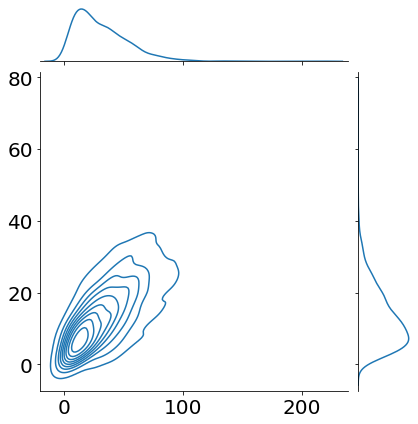

In [14]:
plot = sns.jointplot(observed_counts[:,0], observed_counts[:,1], kind = 'kde')
plt.xlabel('unspliced')
plt.ylabel('spliced');

In [15]:
# now, get the log probabilities for each method by AVERAGING PROBABILITIES -- is it different?

def reconstruct_ct_distribution(gene_name,cell_type,setups,max_vals=[10,10]):
    ''' Calculates the reconstructed probabilities for input gene for 
     all cells in cell type for each setup in setups. Averages probabilities over cells.
     Returns prob_dict with averaged probabilities for the specified gene in the specified cell type for 
     the input setups. 
     max_vals delimits the x,y values to calculate probabilities over.
    '''
    gene = np.where(genes == gene_name)[0][0]
    print(gene_name,gene)
    x,y = max_vals[0],max_vals[1]
    

    x_grid, y_grid = torch.meshgrid(torch.range(0,x), torch.range(0,y))
    X = torch.concat((x_grid,y_grid),axis=1)

    prob_dict = {}

    for setup in setups:

        if 'scVI' in setup:
        # vanilla: 
            N = int(len(results_dict[setup]['params']['mean'][0,:])/2)
            mus_u = results_dict[setup]['params']['mean'][cell_types == cell_type,gene]
            thetas_u = results_dict[setup]['params']['dispersions'][cell_types == cell_type,gene]
            mus_s =  results_dict[setup]['params']['mean'][cell_types == cell_type,gene+N]
            thetas_s = results_dict[setup]['params']['dispersions'][cell_types == cell_type,gene+N]

            mu1 = [torch.ones((x+1,y+1))*mus_u[i] for i in range(len(mus_u))]
            mu2 = [ torch.ones((x+1,y+1))*mus_s[i] for i in range(len(mus_s))]
            theta1 = [torch.ones((x+1,y+1))*thetas_u[i] for i in range(len(thetas_u))]
            theta2 = [torch.ones((x+1,y+1))*thetas_s[i] for i in range(len(thetas_s))]
            theta = [torch.concat((theta1[i],theta2[i]),axis=1) for i in range(len(theta1))]
    
        elif '-' in setup:
            N = int(len(results_dict[setup]['params']['mean'][0,:])/2)
            mus_u = results_dict[setup]['params']['mean'][cell_types == cell_type,gene]
            mus_s =  results_dict[setup]['params']['mean'][cell_types == cell_type,gene+N]
            thetas = results_dict[setup]['params']['dispersions'][cell_types == cell_type,gene]
        
            mu1 = [torch.ones((x+1,y+1))*mus_u[i] for i in range(len(mus_u))]
            mu2 = [ torch.ones((x+1,y+1))*mus_s[i] for i in range(len(mus_u))]
            theta = [torch.ones((x+1,y+1))*thetas[i] for i in range(len(thetas))]

        if "scVI" in setup:
            prob = np.array([torch.exp(log_prob_NBuncorr(X, mu1[i], mu2[i], theta[i], eps = 1e-8, THETA_IS = 'NAS_SHAPE')).numpy()
                    for i in range(len(mu1))])

            prob_dict[setup] = np.sum(prob,axis=0)
        
        elif "Constitutive" in setup:
            prob = np.array([torch.exp(log_prob_poisson(X, mu1[i], mu2[i], theta[i], eps = 1e-8, THETA_IS = 'NAS_SHAPE')).numpy()
                    for i in range(len(mu1))])
            prob_dict[setup] = np.sum(prob,axis=0)
        
        elif "Bursty" in setup:
            prob = np.array([torch.exp(log_prob_nnNB(X.to(torch.device(device)), 
                                   mu1[i].to(torch.device(device)), 
                                   mu2[i].to(torch.device(device)), 
                                   theta[i].to(torch.device(device)), 
                                   eps = 1e-8, THETA_IS = 'NAS_SHAPE')).detach().cpu().numpy()
                                    for i in range(len(mu1))])
            prob_dict[setup] = np.sum(prob,axis=0)
    
        elif "Extrinsic" in setup:
            prob = np.array([torch.exp(log_prob_NBcorr(X, mu1[i], mu2[i], theta[i], eps = 1e-8, THETA_IS = 'NAS_SHAPE')).numpy()
                    for i in range(len(mu1))])
            prob_dict[setup] = np.sum(prob,axis=0)
        
        
        if 'TRUE' in setup:
            b, beta, gamma  = 10**simulated_params[ct,gene,:]
            av_mu_u,av_mu_s = b/beta, b/gamma
            av_theta = 1/beta
            theta = [torch.ones((x+1,y+1))*av_theta for i in range(len(mu1))]
            mu1,mu2 = torch.ones((x+1,y+1))*av_mu_u, torch.ones((x+1,y+1))*av_mu_s
            prob = np.array([torch.exp(log_prob_nnNB(X.to(torch.device(device)), 
                                   mu1[i].to(torch.device(device)), 
                                   mu2[i].to(torch.device(device)), 
                                   theta[i].to(torch.device(device)), 
                                   eps = 1e-8, THETA_IS = 'NAS_SHAPE')).detach().cpu().numpy()
                                    for i in range(len(mu1))])
        
            prob_dict[setup] = np.sum(prob,axis=0)
            
    return(prob_dict)

In [80]:
name_change_dict = {'Bursty-10-NAS_SHAPE':'biVI','scVI-10-NAS_SHAPE':'scVI'}

def get_observed_counts(gene_name, cell_type):
        # subset matrix to get spiced/unspliced counts
        spliced_counts = adata_s[adata_s.obs['Cell Type']==cell_type,adata_u.var['gene_name']==gene_name].layers['counts'].todense()
        unspliced_counts = adata_u[adata_u.obs['Cell Type']==cell_type,adata_s.var['gene_name']==gene_name].layers['counts'].todense()

        # create matrix of observed counts
        observed_counts = np.ones((spliced_counts.shape[0],2))
        observed_counts[:,0] = unspliced_counts.flatten()
        observed_counts[:,1] = spliced_counts.flatten()
        return(observed_counts)
    
    
def plot_distributions(gene_name,cell_type,prob_dict,setups,
                       maxval,
                       vmax_dist,
                       histbins = None,
                       vmax_hist = None,
                       step = 1,
                      plot_observed = True,
                      cmap = 'Purples',
                      save = None):
    ''' Plots the distributions input probability dictionary for the specified setups.
    '''
    
    gene = np.where(genes == gene_name)[0][0]
    
    matplotlib.rc('xtick', labelsize=40) 
    matplotlib.rc('ytick', labelsize=40) 
    
    
    # declare figure
    num_col = len(setups)
    if plot_observed == True:
        num_col += 1 
        
    figure, ax = plt.subplots(1,num_col,figsize = (num_col*6,6))
    i = 0
    
    if plot_observed == True:
        observed_counts = get_observed_counts(gene_name,cell_type)
        ax_ = ax[0]
        count_hist, _, _ = np.histogram2d(observed_counts[:,0],observed_counts[:,1],
                            bins = [np.arange(histbins[0]+1,step=step)-0.5,np.arange(histbins[1]+1,step=step)-0.5],
                            )

#         ax_.hist2d(observed_counts[:,0],observed_counts[:,1],bins=histbins,
#                   range = [[0,xmax+1],[0,ymax+1]],vmin=0.0,vmax = vmax_hist)
        ax_.set_title('Observed',fontsize=fs)
        ax_.imshow(count_hist.T,
                 origin = 'lower',
                 extent = [0.,maxval[0]+1,0.,maxval[1]+1],
                 vmin = 0.0,
                 vmax = vmax_hist,
                 aspect="auto",
                 cmap = cmap)
        ax_.yaxis.get_major_ticks()[0].label1.set_visible(False)
        i += 1 
    
    
    for setup in setups:
        ax_ = ax[i]
        ax_.imshow(prob_dict[setup].T/np.sum(prob_dict[setup]),
                 origin = 'lower',
                 extent = [0.,maxval[0]+1,0.,maxval[1]+1],
                 vmin = 0.0,
                 vmax = vmax_dist,
                 aspect="auto",
                 cmap = cmap)
        name_ = name_change_dict[setup]
        ax_.set_title(name_,fontsize=fs)
        ax_.yaxis.get_major_ticks()[0].label1.set_visible(False)
#         ax_.set_ylabel('$X_S$',fontsize=fs,rotation = 0)
#         ax_.set_xlabel('$X_U$',fontsize=fs)
        i += 1
        
    

        
        
    plt.tight_layout()
    if save != None:
        plt.savefig(f'../../results/{name}_figs/{gene_name}_in_{cell_type}',bbox_inches = 'tight')

In [81]:
setups = ['Bursty-10-NAS_SHAPE','scVI-10-NAS_SHAPE']
gene_list = ['Rorb','Foxp2','Nos1','Cux2']
cmap_list = ['Purples','Blues','Purples','Blues']

cell_type_list = ['L5 IT','L6 CT','L5 IT','L6 CT']
maxval_list = [[75,75],[100,50],[10,10],[10,5]]
histbins_list = [[75+1,75+1],[100+1,50+1],[10+1,10+1],[10+1,5+1]]
vmax_dist = [0.001,0.001,0.009,0.05]
vmax_hist = [10,10,10,60]
step_list = [2,2,1,1]
setup_max = [2,2,1,1]

Rorb 909


<ipython-input-15-42818d737904>:15: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  x_grid, y_grid = torch.meshgrid(torch.range(0,x), torch.range(0,y))


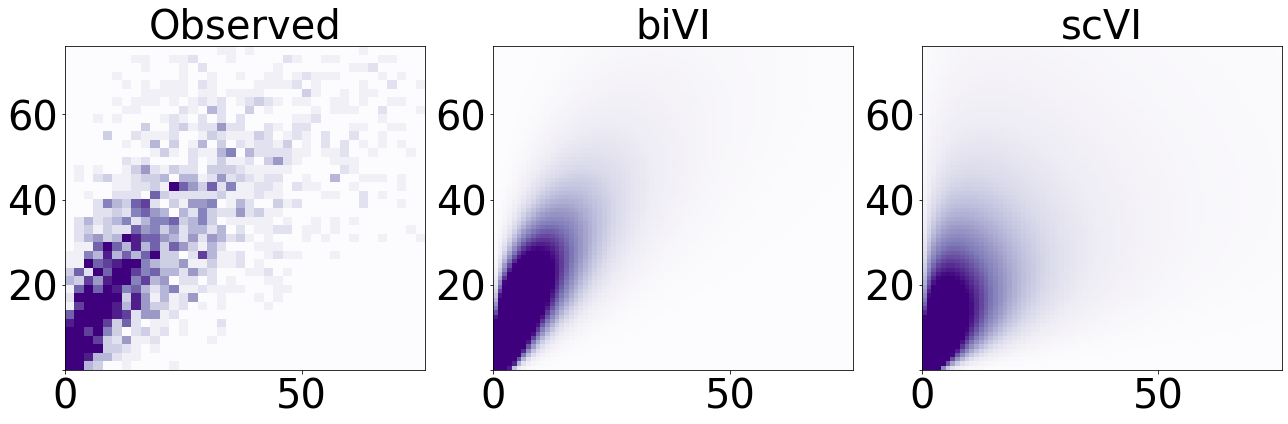

Foxp2 1453


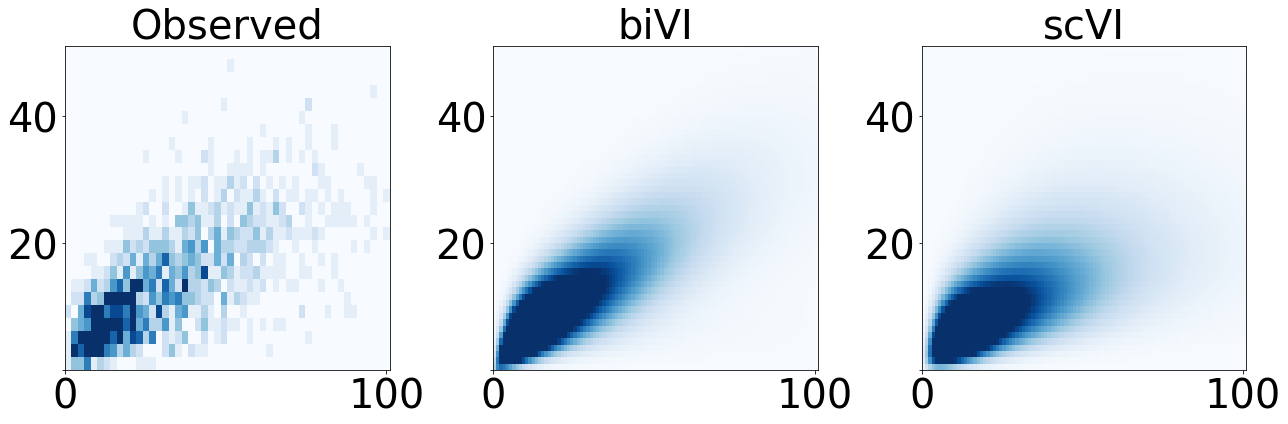

Nos1 1410


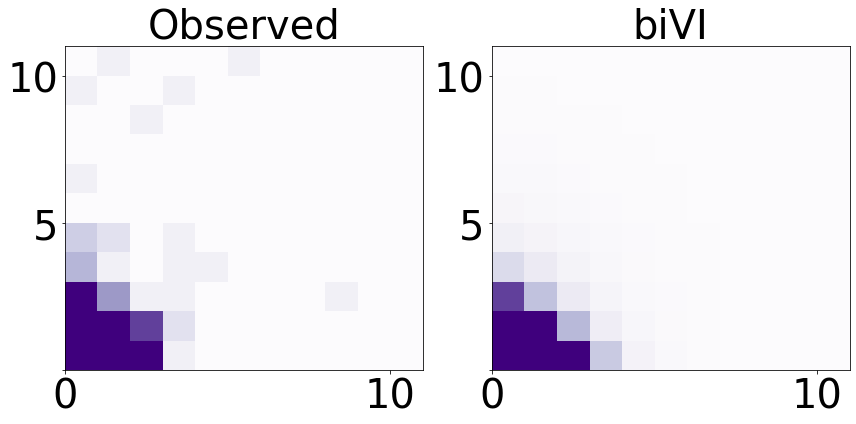

Cux2 1409


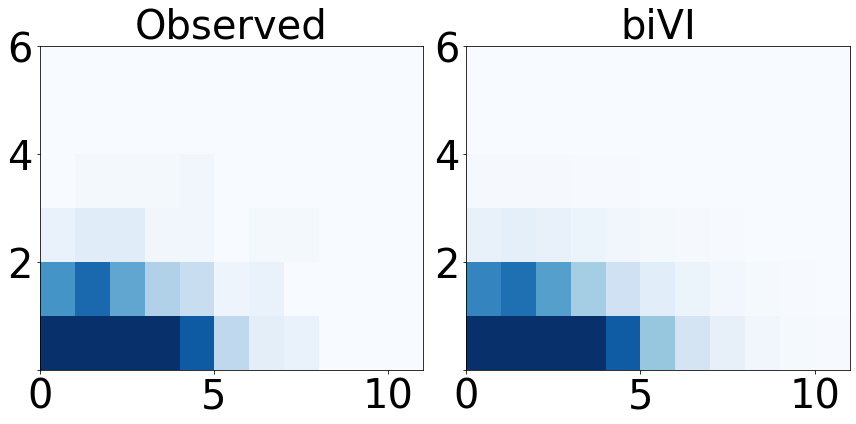

In [82]:

for i,gene_name in enumerate(gene_list):
    prob_dict = reconstruct_ct_distribution(gene_name,
                                            cell_type_list[i],
                                            setups[:setup_max[i]],maxval_list[i])
    plot_distributions(gene_name,
                       cell_type_list[i],
                       prob_dict,setups[:setup_max[i]],
                       maxval = maxval_list[i],
                       vmax_dist = vmax_dist[i],
                       histbins = histbins_list[i],
                       vmax_hist = vmax_hist[i],
                       step = step_list[i],
                       plot_observed = True,
                       cmap = cmap_list[i],
                       save = True)
    plt.show()
    
    

And plot!

-----

# Distribution of Gene Parameters



Distribution of gene parameters for different models, different cell types. 

In [83]:
def get_bursty_params(mu1,mu2,theta):
    ''' Returns b, beta, gamma of bursty distribution given mu1, mu2 and theta.
    Returns whatever size was input. 
    '''
    
    b = mu1/theta
    beta = 1/theta
    gamma = mu1/(mu2*theta)
    
    
    return(b,beta,gamma)


def get_BVNB_params(mu1,mu2,theta):
    ''' Returns splicing rate beta, degradation rate gamma, and alpha (mean of transcription rate distribution) 
    given BVNB extrinsic noise model.
    '''
    alpha = theta
    beta = theta/mu1
    gamma = theta/mu2
    
    
    return(alpha,beta,gamma)

def get_constitutive_params(mu1,mu2):
    ''' Returns rate of splicing rate beta and rate of degradation gamma given constitutive model.
    '''
    beta = 1/mu1
    gamma = 1/mu2
    
    return(beta,gamma)
    

Look at distributions across cell type.


In [84]:
def plot_parameters(gene_name,chosen_cell_type,save=False,
                    color_code = 'bw',
                    cmap = 'Purples',
                    plot_means = True):
    ''' Plots for all cells the inferred parameters.
    '''
    setup = 'Bursty-10-NAS_SHAPE'
    gene = np.where(genes == gene_name)[0][0]
    
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    
    
    if plot_means == True:
        nsubplots = 2
        width = 15
    else:
        nsubplots = 1
        width = 11

    fig, ax = plt.subplots(1,nsubplots, figsize = (width,6))
    
    # CHANGE TO CHANGE COLORMAP
    cm = plt.get_cmap('rainbow')
    
    for i,cell_type in enumerate(cluster_labels):
        
        
        if (cell_type == chosen_cell_type) and (color_code) == 'bw':
            color = plt.get_cmap(cmap)(200)
            z_order = 1
        elif color_code == 'color':
            color = cm(i*13)
            z_order = -1
        elif (cell_type != chosen_cell_type) and color_code == 'bw':
            color = 'darkgray'
            z_order = -1
            
        
        N = int(len(results_dict[setup]['params']['mean'][0,:])/2)
        mu1 = results_dict[setup]['params']['mean'][cell_types==cell_type,gene]
        mu2 =  results_dict[setup]['params']['mean'][cell_types==cell_type,gene+N]
        theta = results_dict[setup]['params']['dispersions'][cell_types==cell_type,gene]
    
        if setup == 'Bursty-10-NAS_SHAPE':
            b,beta,gamma = get_bursty_params(mu1,mu2,theta)
        elif model == 'Constitutive-10-NAS_SHAPE':
            beta,gamma = get_constitutive_params(mu1,mu2)
        elif model == 'Extrinsic-10-NAS_SHAPE':
            alpha,beta,gamma = get_BVNB_params(mu1,mu2,theta)
    
    
        
        
        if plot_means == True:
            ax[0].scatter(b,gamma,s=2,label=f'{cell_type}',color=color,zorder=z_order)
            ax[0].set_ylabel('$\gamma/k$',fontsize = fs)
            ax[0].set_xlabel('$b$', fontsize = fs)
            ax[0].set_xscale('log')
            ax[0].set_yscale('log')
            ax[0].tick_params(labelsize = 25)
            #ax[0].grid(visible= True)
        
            ax[1].scatter(mu1,mu2,s=2,label=f'{cell_type}',color=color,zorder=z_order)
            ax[1].set_xlabel('$\mu_N$', fontsize = fs)
            ax[1].set_ylabel('$\mu_M$',fontsize = fs)
            ax[1].set_xscale('log')
            ax[1].set_yscale('log')
            ax[1].tick_params(labelsize = 25)
            #ax[1].grid(visible= True)
        
        else:
            ax.scatter(b,gamma,s=2,label=f'{cell_type}',color=color,zorder=z_order)
            ax.set_ylabel('$\gamma/k$',fontsize = fs)
            ax.set_xlabel('$b$', fontsize = fs)
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.tick_params(labelsize = 25)
            #ax.grid(visible= True)
        
    
    

    plt.legend(bbox_to_anchor=(1.1, 0.95),fontsize = 11.5,markerscale=4.,ncol=2)
    plt.suptitle(f'Gene {gene_name}',fontsize = 40)

   
    #plt.grid()
    #ax.yaxis.set_major_formatter(formatter) 
    plt.tight_layout()
    
    if save == True and plot_means == True:
        plt.savefig(f'../../results/{name}_figs/params_{gene_name}_{color_code}_nomeans.png',bbox_inches = 'tight')
    elif save == True and plot_means == False:
        plt.savefig(f'../../results/{name}_figs/params_gene{gene_name}_{color_code}.png',bbox_inches = 'tight')

Rorb
L5 IT
Foxp2
L6 CT
Nos1
L5 IT
Cux2
L6 CT


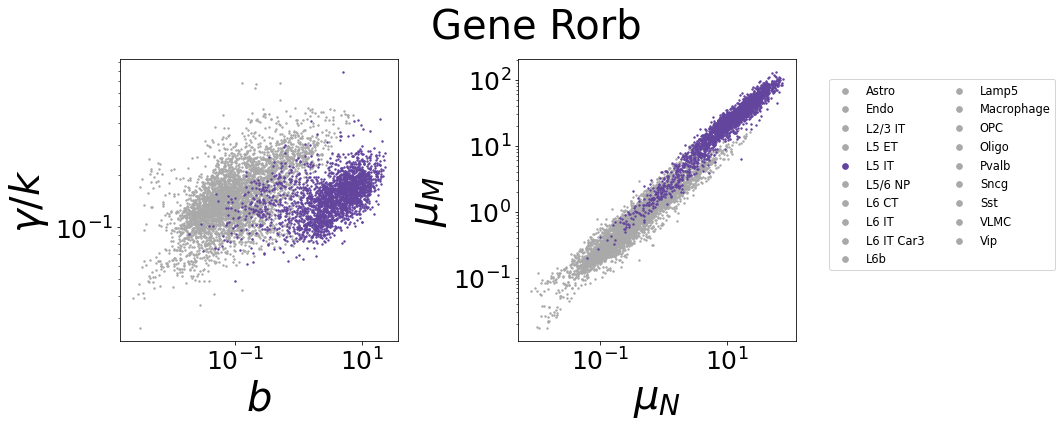

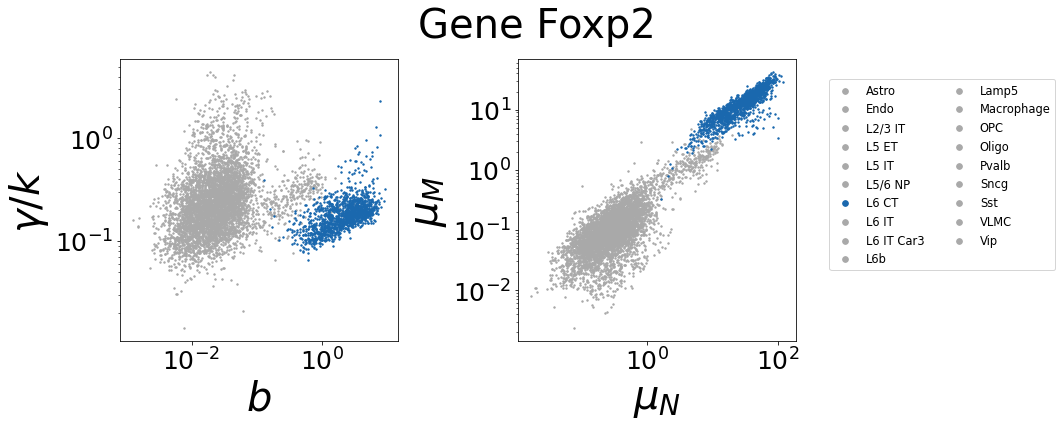

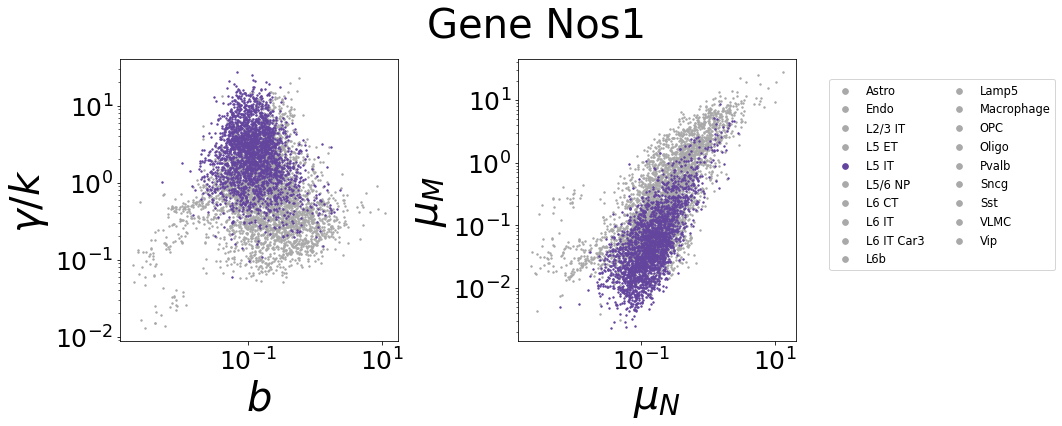

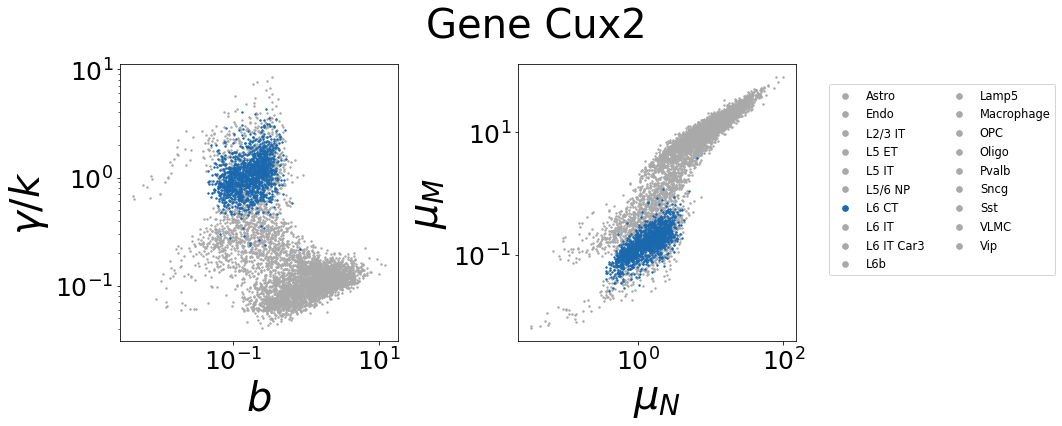

In [85]:
for i,gene in enumerate(gene_list):
    print(gene)
    print(cell_type_list[i])
    plot_parameters(gene,cell_type_list[i],color_code='bw',cmap = cmap_list[i],save=True)
    #plot_parameters(gene,cell_type_list[i],color_code='color',save=True)

Rorb
L5 IT
Foxp2
L6 CT
Nos1
L5 IT
Cux2
L6 CT


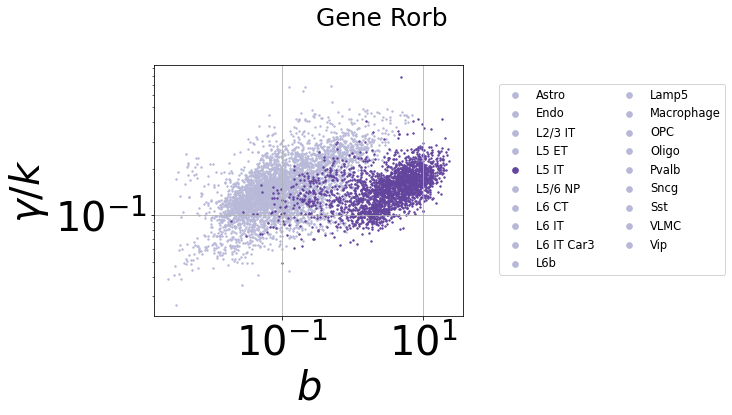

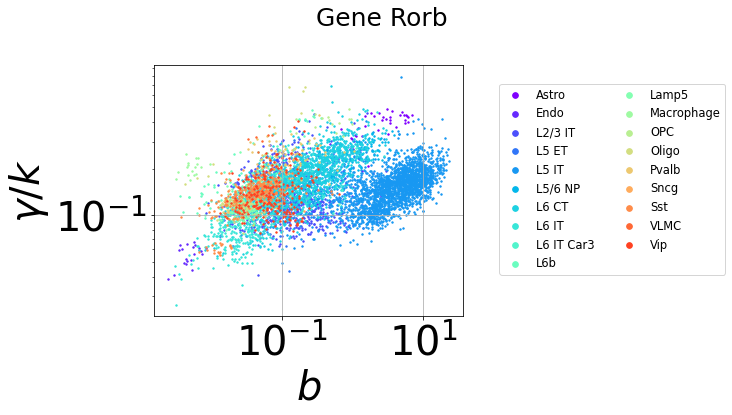

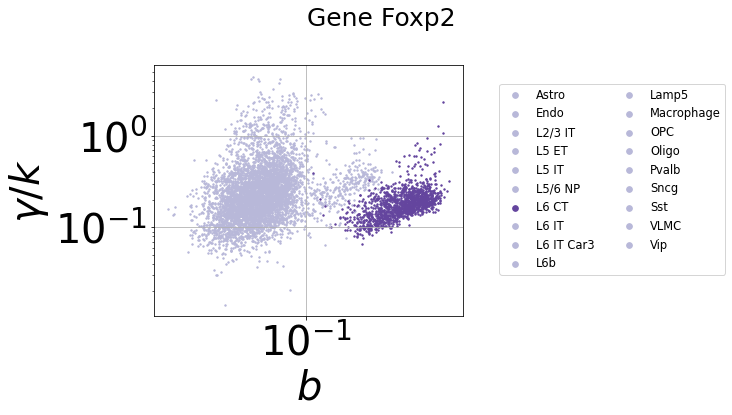

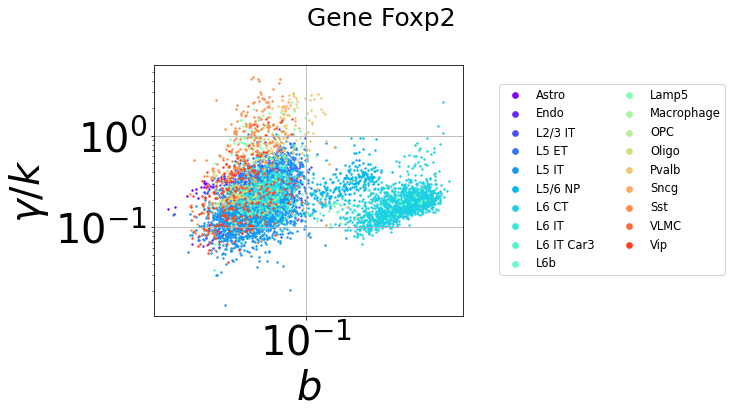

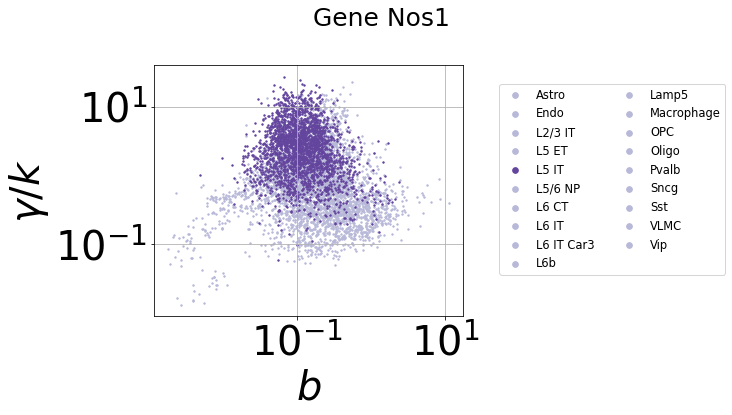

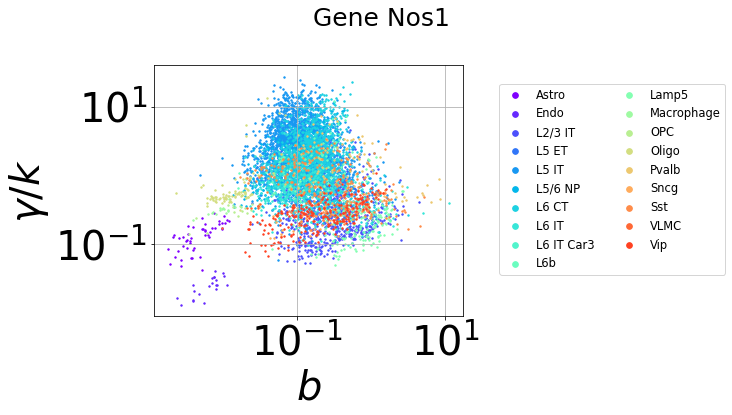

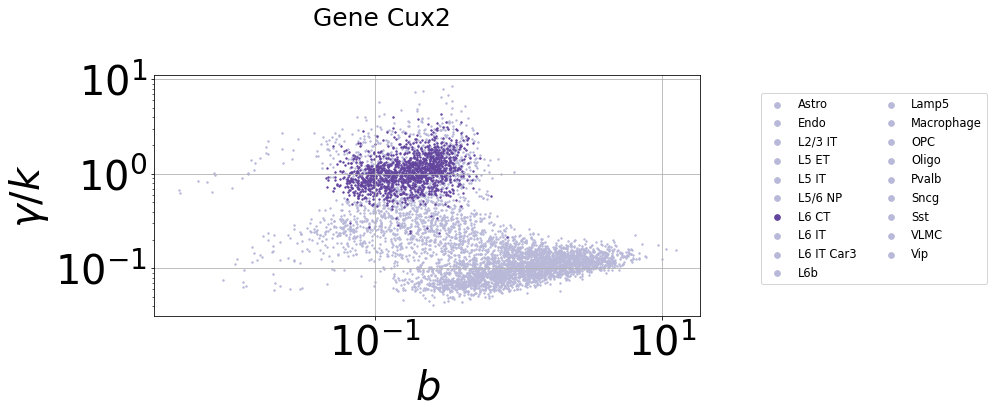

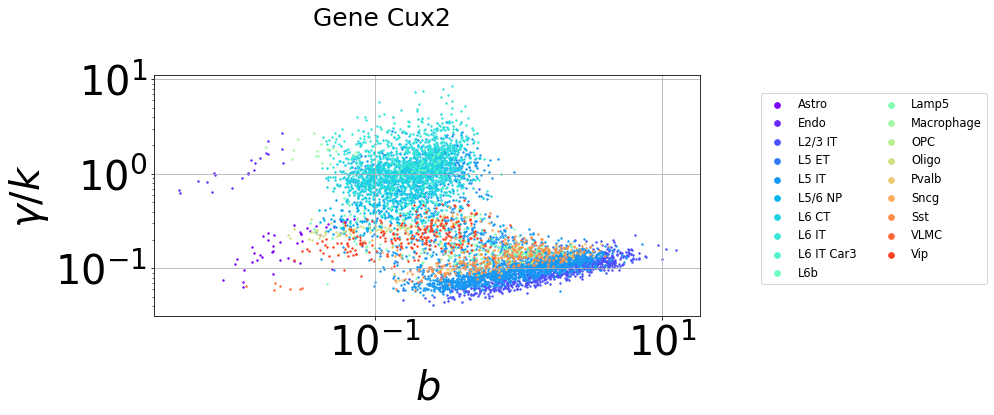

In [882]:
for i,gene in enumerate(gene_list):
    print(gene)
    print(cell_type_list[i])
    plot_parameters(gene,cell_type_list[i],color_code='bw',plot_means =  False, save=True)
    plot_parameters(gene,cell_type_list[i],color_code='color',plot_means = False,save=True)

In [71]:
def plot_param_distribution(gene_name,cell_type_list,parameter,colors,ax = None, save=False, legend = False):
    
    gene = np.where(genes == gene_name)[0][0]
    setup = 'Bursty-10-NAS_SHAPE'
    
    cm = plt.get_cmap('Purples')
    
    plt.figure(figsize = (10,5))
    for i,cell_type in enumerate(cell_type_list):
        
        N = int(len(results_dict[setup]['params']['mean'][0,:])/2)
        mu1 = results_dict[setup]['params']['mean'][cell_types==cell_type,gene]
        mu2 =  results_dict[setup]['params']['mean'][cell_types==cell_type,gene+N]
        theta = results_dict[setup]['params']['dispersions'][cell_types==cell_type,gene]
        
        
        mu1_scVI = results_dict['scVI-10-NAS_SHAPE']['params']['mean'][cell_types==cell_type,gene]
        mu2_scVI =  results_dict['scVI-10-NAS_SHAPE']['params']['mean'][cell_types==cell_type,gene+N]
        
        if setup == 'Bursty-10-NAS_SHAPE':
            b,beta,gamma = get_bursty_params(mu1,mu2,theta)
        elif model == 'Constitutive-10-NAS_SHAPE':
            beta,gamma = get_constitutive_params(mu1,mu2)
        elif model == 'Extrinsic-10-NAS_SHAPE':
            alpha,beta,gamma = get_BVNB_params(mu1,mu2,theta)
        if parameter == 'mu1':
            param = mu1
        if parameter == 'mu2':
            param = mu2
        if parameter == '$\mu_N$':
            param = mu1_scVI
        if parameter == '$\mu_M$':
            param = mu2_scVI
        if parameter == 'b':
            param = b
        if parameter == '$beta/k$':
            param = beta
        if parameter == '$\gamma/k$':
            param = gamma
        if parameter == '$\gamma/k$':
            save_name = 'gamma'
        else:
            save_name = parameter
    
        sns.histplot(np.log(param),color=colors[i],kde=True,label=cell_type,ax = ax)
        
    ax.set_xlabel('Log$_{10}$ '+f'{parameter}',fontsize = fs)
    ax.set_ylabel('Count',fontsize = fs)
    if legend == True:
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left',prop={'size': 60})
    ax.set_title(f'${gene_name}$',fontsize = fs)
    
    if save == True:
        plt.savefig(f'../../results/{name}_figs/{gene_name}_{save_name}_hist.png',bbox_inches = 'tight')

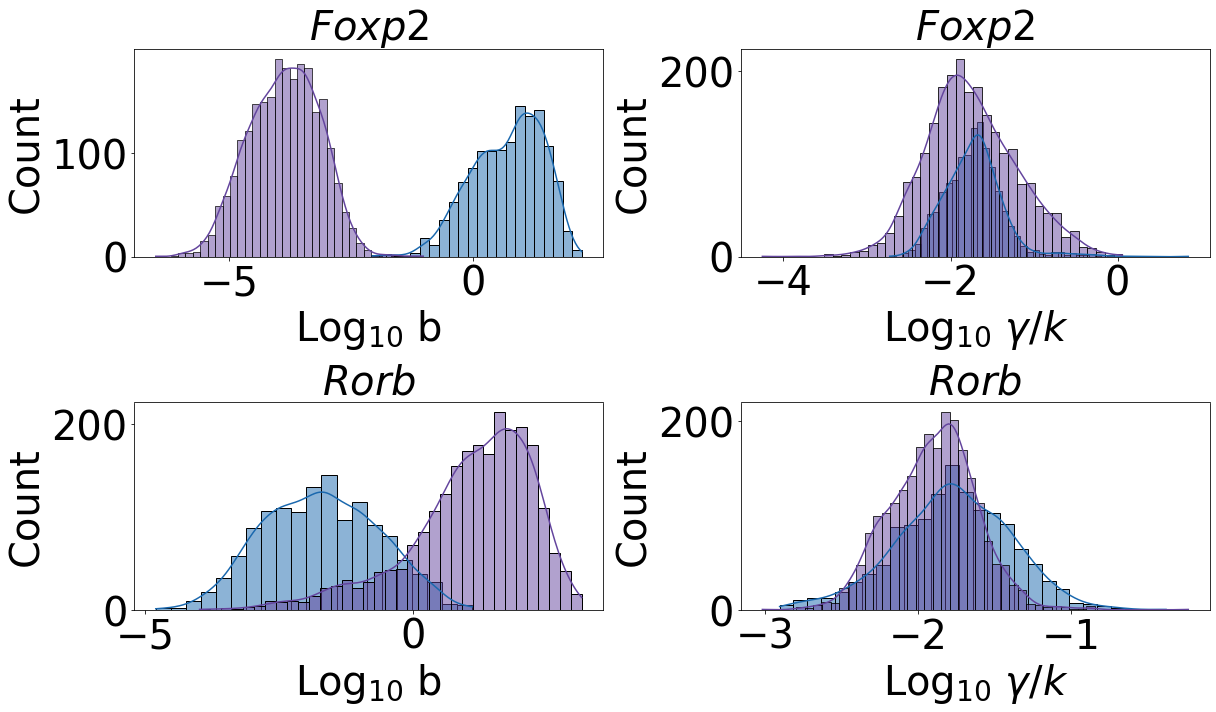

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [46]:
fig, axis1 = plt.subplots(2,2,figsize = (17,10))
plot_param_distribution('Foxp2',['L6 CT','L5 IT'],parameter='b',
                        colors = [plt.get_cmap('Blues')(200),plt.get_cmap('Purples')(200)],
                        ax = axis1[0,0],save=False)
plot_param_distribution('Foxp2',['L6 CT','L5 IT'],parameter='$\gamma/k$',
                        colors = [plt.get_cmap('Blues')(200),plt.get_cmap('Purples')(200)],
                        ax = axis1[0,1],save=False)
plot_param_distribution('Rorb',['L6 CT','L5 IT'],parameter='b',
                        colors = [plt.get_cmap('Blues')(200),plt.get_cmap('Purples')(200)],
                        ax = axis1[1,0],save=False)
plot_param_distribution('Rorb',['L6 CT','L5 IT'],parameter='$\gamma/k$',
                        colors = [plt.get_cmap('Blues')(200),plt.get_cmap('Purples')(200)],
                        ax = axis1[1,1],save=False)

fig.tight_layout()
fig.savefig(f'../../results/{name}_figs/Foxp2_Rorb_grid_hist.png',bbox_inches = 'tight')

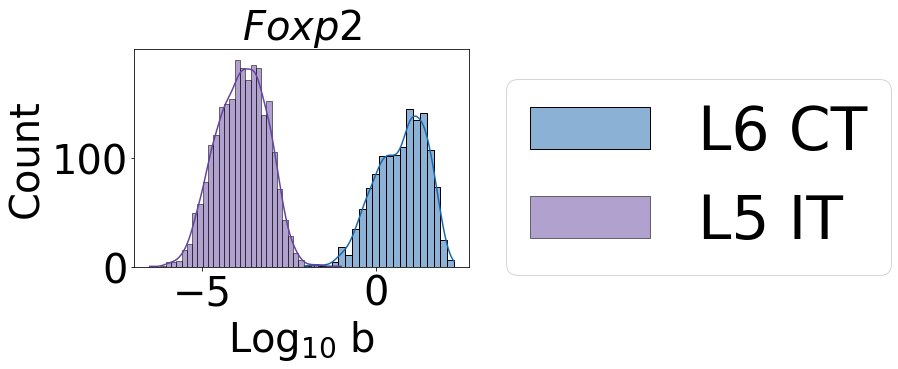

<Figure size 720x360 with 0 Axes>

In [47]:
fig, ax = plt.subplots(1,1)
plot_param_distribution('Foxp2',['L6 CT','L5 IT'],parameter='b',
                        colors = [plt.get_cmap('Blues')(200),plt.get_cmap('Purples')(200)],
                        ax = ax, save=False, legend = True)
fig.savefig(f'../../results/{name}_figs/Foxp2_b_hist_large_label.png',bbox_inches = 'tight')

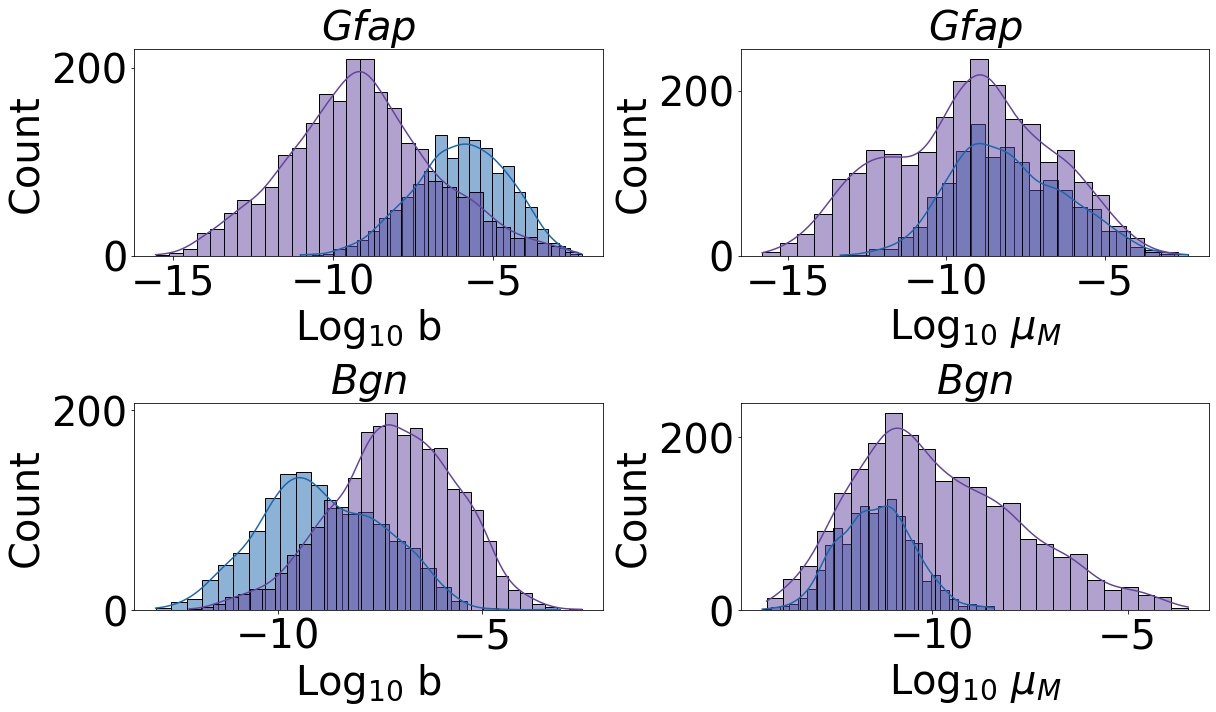

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [75]:
gene1 = 'Gfap'
gene2 = 'Bgn'

fig, axis1 = plt.subplots(2,2,figsize = (17,10))
plot_param_distribution(gene1,['L6 CT','L5 IT'],parameter='b',
                        colors = [plt.get_cmap('Blues')(200),plt.get_cmap('Purples')(200)],
                        ax = axis1[0,0],save=False)
plot_param_distribution(gene1,['L6 CT','L5 IT'],parameter='$\mu_M$',
                        colors = [plt.get_cmap('Blues')(200),plt.get_cmap('Purples')(200)],
                        ax = axis1[0,1],save=False)
plot_param_distribution(gene2,['L6 CT','L5 IT'],parameter='b',
                        colors = [plt.get_cmap('Blues')(200),plt.get_cmap('Purples')(200)],
                        ax = axis1[1,0],save=False)
plot_param_distribution(gene2,['L6 CT','L5 IT'],parameter='$\mu_M$',
                        colors = [plt.get_cmap('Blues')(200),plt.get_cmap('Purples')(200)],
                        ax = axis1[1,1],save=False)
fig.tight_layout()

fig.savefig(f'../../results/{name}_figs/{gene1}_{gene2}_b_mu2_hist.png',bbox_inches = 'tight')